In [1]:
import ast
import itertools
import pathlib
import sys
import warnings

import joblib
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import toml
from joblib import dump
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV, LogisticRegression

# import mse
from sklearn.metrics import mean_squared_error, r2_score

# import RepeatedKFold
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.utils import parallel_backend, shuffle

In [2]:
# Parameters
cell_type = "PBMC"
aggregation = True
nomic = True
flag = True
control = "DMSO_0.100_DMSO_0.025"
treatment = "LPS_100.000_DMSO_0.025"

In [3]:
MODEL_TYPE = "regression"
if flag == False:
    # read in toml file and get parameters
    toml_path = pathlib.Path("single_class_config.toml")
    with open(toml_path, "r") as f:
        config = toml.load(f)
    control = config["logistic_regression_params"]["control"]
    treatment = config["logistic_regression_params"]["treatments"]
    aggregation = ast.literal_eval(config["logistic_regression_params"]["aggregation"])
    nomic = ast.literal_eval(config["logistic_regression_params"]["nomic"])
    cell_type = config["logistic_regression_params"]["cell_type"]

In [4]:
# load training data from indexes and features dataframe
# data_split_path = pathlib.Path(f"../0.split_data/indexes/data_split_indexes.tsv")
# data_path = pathlib.Path(f"../../data/{cell_type}_preprocessed_sc_norm.parquet")
data_path = pathlib.Path(
    "../../data/PBMC_subset_sc_norm_DMSO_0.100_DMSO_0.025_LPS_100.000_DMSO_0.025.parquet"
)

# dataframe with only the labeled data we want (exclude certain phenotypic classes)
data_df = pq.read_table(data_path).to_pandas()

# import nomic data
nomic_df_path = pathlib.Path(
    f"../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_{cell_type}_cleanup4correlation.csv"
)
df_nomic = pd.read_csv(nomic_df_path)

# clean up nomic data
df_nomic = df_nomic.drop(columns=[col for col in df_nomic.columns if "[pgML]" in col])
# drop first 25 columns (Metadata that is not needed)
# df_nomic = df_nomic.drop(columns=df_nomic.columns[3:25])
# df_nomic = df_nomic.drop(columns=df_nomic.columns[0:2])

In [5]:
df_nomic

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Metadata_position_x,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,fourb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.097710,0.461685,0.270477,0.514695,0.479281,0.270494,0.708849,0.134432,0.350986,0.216932,...,0.560129,0.504521,0.490444,0.258834,0.238358,0.524276,0.250670,B06,DMSO_0.100_DMSO_0.025,DMSO__0.100__DMSO__0.025
1,0.064513,0.451181,0.246274,0.471026,0.269795,0.204498,0.247611,0.322087,0.350642,0.349237,...,0.476656,0.315426,0.589522,0.381170,0.168645,0.455092,0.228752,C06,DMSO_0.100_DMSO_0.025,DMSO__0.100__DMSO__0.025
2,0.061860,0.196318,0.236491,0.474891,0.174672,0.824721,0.704521,0.254823,0.443939,0.268677,...,0.389375,0.369421,0.680276,0.182956,0.263281,0.213596,0.064645,I06,DMSO_0.100_DMSO_0.025,DMSO__0.100__DMSO__0.025
3,0.060998,0.596601,0.129926,0.302610,0.559309,0.087533,0.541110,0.350256,0.528260,0.313411,...,0.258029,0.561051,0.551671,0.582053,0.087565,0.140992,0.234191,J06,DMSO_0.100_DMSO_0.025,DMSO__0.100__DMSO__0.025
4,0.061116,0.490832,0.339510,0.453362,0.414653,0.424223,0.702561,0.203464,0.502516,0.363301,...,0.615867,0.288153,0.506528,0.264141,0.296782,0.541689,0.167078,B07,DMSO_0.100_DMSO_0.025,DMSO__0.100__DMSO__0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.043200,0.257949,0.227103,0.565494,0.260330,0.523500,0.788839,0.425712,0.398209,0.317449,...,0.432374,0.310545,0.568101,0.275941,0.312566,0.286031,0.288358,O05,media ctr_nan_Media ctr_nan,media ctr__nan__Media ctr__nan
150,0.072687,0.379701,0.308980,0.537718,0.640661,0.502533,0.451720,0.385627,0.371089,0.190994,...,0.628378,0.190684,0.636181,0.450715,0.178011,0.621119,0.229238,O10,media ctr_nan_Media ctr_nan,media ctr__nan__Media ctr__nan
151,0.081503,0.161844,0.316893,0.433801,0.630864,0.577818,0.576989,0.348813,0.362100,0.311019,...,0.620522,0.423500,0.785011,0.308965,0.268730,0.613026,0.254080,O11,media ctr_nan_Media_nan,media ctr__nan__Media__nan
152,0.062455,0.639999,0.334726,0.425654,0.281513,0.488874,0.734609,0.232744,0.425711,0.368349,...,0.528663,0.487337,0.439436,0.161322,0.296984,0.625991,0.297158,B12,media ctr_nan_Media ctr_nan,media ctr__nan__Media ctr__nan


In [6]:
if (aggregation == True) and (nomic == True):
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/aggregated_sc_and_nomic_data_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
    # subset each column that contains metadata
    metadata = data_df.filter(regex="Metadata")
    data_df = data_df.drop(metadata.columns, axis=1)
    data_df = pd.concat([data_df, metadata["Metadata_Well"]], axis=1)
    # groupby well and take mean of each well
    data_df = data_df.groupby("Metadata_Well").mean()
    # drop duplicate rows in the metadata_well column
    metadata = metadata.drop_duplicates(subset=["Metadata_Well"])
    # get the metadata for each well
    data_df = pd.merge(
        data_df, metadata, left_on="Metadata_Well", right_on="Metadata_Well"
    )
    data_df = pd.merge(
        data_df,
        df_nomic,
        left_on=["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        right_on=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
    )
    data_df = data_df.drop(columns=["Metadata_position_x"])
elif (aggregation == True) and (nomic == False):
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/aggregated_sc_data_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
    # subset each column that contains metadata
    metadata = data_df.filter(regex="Metadata")
    data_df = data_df.drop(metadata.columns, axis=1)
    data_df = pd.concat([data_df, metadata["Metadata_Well"]], axis=1)
    # groupby well and take mean of each well
    data_df = data_df.groupby("Metadata_Well").mean()
    # drop duplicate rows in the metadata_well column
    metadata = metadata.drop_duplicates(subset=["Metadata_Well"])
    # get the metadata for each well
    data_df = pd.merge(
        data_df,
        df_nomic,
        left_on=["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        right_on=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
    )
elif (aggregation == False) and (nomic == True):
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/sc_and_nomic_data_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
    data_df = pd.merge(
        data_df,
        df_nomic,
        left_on=["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        right_on=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
    )
    data_df = data_df.drop(columns=["Metadata_position_x"])
elif aggregation == False and nomic == False:
    data_split_path = pathlib.Path(
        f"../0.split_data/indexes/{cell_type}/{MODEL_TYPE}/{control}_{treatment}/sc_split_indexes.tsv"
    )
    data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
else:
    print("Error")

In [7]:
# select tht indexes for the training and test set
train_indexes = data_split_indexes.loc[data_split_indexes["label"] == "train"]
test_indexes = data_split_indexes.loc[data_split_indexes["label"] == "test"]

In [8]:
# subset data_df by indexes in data_split_indexes
training_data = data_df.loc[train_indexes["labeled_data_index"]]
testing_data = data_df.loc[test_indexes["labeled_data_index"]]

,Metadata_Well,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,Cytoplasm_AreaShape_Zernike_2_2,...,uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],fourb_Metadata_Treatment_Dose_Inhibitor_Dose_y
3,C07,0.028173,-0.028884,0.053797,0.075352,0.009324,0.011514,0.018833,-0.006253,0.011076,...,0.080217,0.270489,0.209407,0.541430,0.811390,0.765569,0.217890,0.568410,0.244602,DMSO__0.100__DMSO__0.025
5,I07,-0.100867,0.076349,-0.117207,-0.154152,-0.011498,0.024456,-0.014095,0.037949,-0.000417,...,0.541786,0.371186,0.554892,0.435451,0.555623,0.191747,0.080188,0.548119,0.126041,DMSO__0.100__DMSO__0.025
7,J03,-0.088240,0.079568,-0.076944,-0.185484,-0.006412,-0.074475,-0.115477,0.062510,-0.035476,...,0.311454,0.430655,0.398244,0.281372,0.506223,0.397721,0.731173,0.618022,0.267031,LPS__100.000__DMSO__0.025


In [9]:
# get oneb_Metadata_Treatment_Dose_Inhibitor_Dose  =='DMSO_0.100_DMSO_0.025' and 'LPS_100.000_DMSO_0.025 and Thapsigargin_10.000_DMSO_0.025'
training_data = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [control, treatment]
    )
]
testing_data = testing_data[
    testing_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [control, treatment]
    )
]

In [10]:
testing_data

,Metadata_Well,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,Cytoplasm_AreaShape_Zernike_2_2,...,uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],fourb_Metadata_Treatment_Dose_Inhibitor_Dose_y
3,C07,0.028173,-0.028884,0.053797,0.075352,0.009324,0.011514,0.018833,-0.006253,0.011076,...,0.080217,0.270489,0.209407,0.541430,0.811390,0.765569,0.217890,0.568410,0.244602,DMSO__0.100__DMSO__0.025
5,I07,-0.100867,0.076349,-0.117207,-0.154152,-0.011498,0.024456,-0.014095,0.037949,-0.000417,...,0.541786,0.371186,0.554892,0.435451,0.555623,0.191747,0.080188,0.548119,0.126041,DMSO__0.100__DMSO__0.025
7,J03,-0.088240,0.079568,-0.076944,-0.185484,-0.006412,-0.074475,-0.115477,0.062510,-0.035476,...,0.311454,0.430655,0.398244,0.281372,0.506223,0.397721,0.731173,0.618022,0.267031,LPS__100.000__DMSO__0.025


In [11]:
# at random downsample the DMSO treatment to match the number of wells in the LPS treatment
seed = 0
# get the number of wells in the LPS treatment
trt_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == treatment
].shape[0]
# get the number of wells in the DMSO treatment
dmso_wells = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].shape[0]
# downsample the DMSO treatment to match the number of wells in the LPS treatment
dmso_holdout = training_data[
    training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == control
].sample(n=trt_wells, random_state=seed)
# remove the downsampled DMSO wells from the data
training_data = training_data.drop(dmso_holdout.index)

In [12]:
# define metadata columns
# subset each column that contains metadata
metadata = training_data.filter(regex="Metadata")
# drop all metadata columns
train_data_x = training_data.drop(metadata.columns, axis=1)
train_treatments = training_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
# get all columns that contain "NSU" in the column name
train_data_y_cols = train_data_x.filter(regex="NSU").columns
train_data_y = training_data[train_data_y_cols]
train_data_x = train_data_x.drop(train_data_y_cols, axis=1)


# define metadata columns
# subset each column that contains metadata
metadata = testing_data.filter(regex="Metadata")
# drop all metadata columns
test_data_x = testing_data.drop(metadata.columns, axis=1)
test_treatments = testing_data["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
# get all columns that contain "NSU" in the column name
test_data_y_cols = test_data_x.filter(regex="NSU").columns
test_data_y = testing_data[test_data_y_cols]
test_data_x = test_data_x.drop(test_data_y_cols, axis=1)

In [13]:
testing_data

,Metadata_Well,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,Cytoplasm_AreaShape_Zernike_2_2,...,uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],fourb_Metadata_Treatment_Dose_Inhibitor_Dose_y
3,C07,0.028173,-0.028884,0.053797,0.075352,0.009324,0.011514,0.018833,-0.006253,0.011076,...,0.080217,0.270489,0.209407,0.541430,0.811390,0.765569,0.217890,0.568410,0.244602,DMSO__0.100__DMSO__0.025
5,I07,-0.100867,0.076349,-0.117207,-0.154152,-0.011498,0.024456,-0.014095,0.037949,-0.000417,...,0.541786,0.371186,0.554892,0.435451,0.555623,0.191747,0.080188,0.548119,0.126041,DMSO__0.100__DMSO__0.025
7,J03,-0.088240,0.079568,-0.076944,-0.185484,-0.006412,-0.074475,-0.115477,0.062510,-0.035476,...,0.311454,0.430655,0.398244,0.281372,0.506223,0.397721,0.731173,0.618022,0.267031,LPS__100.000__DMSO__0.025


In [14]:
print(train_data_x.shape, train_data_y.shape, test_data_x.shape, test_data_y.shape)

(6, 1245) (6, 187) (3, 1245) (3, 187)


In [15]:
# set model path from parameters
if (aggregation == True) and (nomic == True):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/aggregated_with_nomic/{MODEL_TYPE}/{control}__{treatment}"
    )
elif (aggregation == True) and (nomic == False):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/aggregated/{MODEL_TYPE}/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == True):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/sc_with_nomic/{MODEL_TYPE}/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == False):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/sc/{MODEL_TYPE}/{control}__{treatment}"
    )
else:
    print("Error")

In [16]:
# col = 'Activin A [NSU]'
compiled_predictions = pd.DataFrame(
    columns=[
        "Prediction",
        "Actual_value",
        "data_split",
        "shuffled",
        "feature_type",
        "MSE",
        "r2",
        "feature",
        "treatment",
    ]
)
shuffles = ["final", "shuffled_baseline"]
feature_types = ["CP"]
evaluation_types = ["train", "test"]
for col in train_data_y.columns:
    # test model on testing data
    for shuffle, feature_type, evaluation_type in itertools.product(
        shuffles, feature_types, evaluation_types
    ):
        model = joblib.load(
            f"../1.train_models/{model_path}/{shuffle}__{feature_type}_{col}.joblib"
        )

        if evaluation_type == "train":
            data_y = train_data_y[col]
            # get row that are labeled train in label column
            # train_data_x = data_x.loc[data_x["label"] == "train"]
            # train_data_x = train_data_x.drop("label", axis=1)
            if shuffle == "shuffled_baseline":
                for column in train_data_x:
                    np.random.shuffle(train_data_x[column].values)
            predictions = model.predict(train_data_x)
            # get probabilities
            # probabilities = model.predict_proba(train_data_x)
            # get accuracy
            MSE = mean_squared_error(data_y, predictions)
            # get r2 score
            r2 = r2_score(data_y, predictions)
            train_predictions_df = pd.DataFrame(
                {
                    "Prediction": predictions,
                    "Actual_value": data_y,
                    "data_split": evaluation_type,
                    "shuffled": "shuffled" in shuffle,
                    "feature_type": feature_type,
                    "MSE": MSE,
                    "r2": r2,
                    "feature": col,
                }
            )
            # oneb_Metadata_Treatment_Dose_Inhibitor_Dose
            train_predictions_df["treatment"] = train_treatments

            compiled_predictions = pd.concat(
                [compiled_predictions, train_predictions_df], axis=0, ignore_index=True
            )
        elif evaluation_type == "test":

            data_y = test_data_y[col]
            # get row that are labeled train in label column
            # train_data_x = data_x.loc[data_x["label"] == "train"]
            # train_data_x = train_data_x.drop("label", axis=1)
            if shuffle == "shuffled_baseline":
                for column in test_data_x:
                    np.random.shuffle(test_data_x[column].values)
            predictions = model.predict(test_data_x)
            print(predictions, data_y)
            # get probabilities
            # probabilities = model.predict_proba(train_data_x)
            # get accuracy
            MSE = mean_squared_error(data_y, predictions)
            # get r2 score
            r2 = r2_score(data_y, predictions)
            test_predictions_df = pd.DataFrame(
                {
                    "Prediction": predictions,
                    "Actual_value": data_y,
                    "data_split": evaluation_type,
                    "shuffled": "shuffled" in shuffle,
                    "feature_type": feature_type,
                    "MSE": MSE,
                    "r2": r2,
                    "feature": col,
                }
            )
            # oneb_Metadata_Treatment_Dose_Inhibitor_Dose
            test_predictions_df["treatment"] = test_treatments

            compiled_predictions = pd.concat(
                [compiled_predictions, test_predictions_df], axis=0, ignore_index=True
            )

[0.15453991 0.31621815 0.74781004] 3    0.053236
5    0.093970
7    0.957122
Name: Activin A [NSU], dtype: float64
[0.40859862 0.40859862 0.40859862] 3    0.053236
5    0.093970
7    0.957122
Name: Activin A [NSU], dtype: float64
[0.38605943 0.49105048 0.44111758] 3    0.541287
5    0.504350
7    0.280560
Name: AITRL (GITR Ligand) [NSU], dtype: float64
[0.40301358 0.62931668 0.6474698 ] 3    0.541287
5    0.504350
7    0.280560
Name: AITRL (GITR Ligand) [NSU], dtype: float64
[0.76203511 0.14087641 0.02833779] 3    0.232002
5    0.226351
7    0.896048
Name: Amphiregulin [NSU], dtype: float64
[0.45917723 0.65464391 0.62707113] 3    0.232002
5    0.226351
7    0.896048
Name: Amphiregulin [NSU], dtype: float64
[0.4101162 0.4101162 0.4101162] 3    0.342847
5    0.578092
7    0.261544
Name: Amyloid beta [NSU], dtype: float64
[0.4101162 0.4101162 0.4101162] 3    0.342847
5    0.578092
7    0.261544
Name: Amyloid beta [NSU], dtype: float64
[0.32605475 0.32123281 0.2988593 ] 3    0.415787
5    

In [17]:
compiled_predictions = compiled_predictions[
    compiled_predictions["feature"] == "IL-1 beta [NSU]"
]
compiled_predictions

,Prediction,Actual_value,data_split,shuffled,feature_type,MSE,r2,feature,treatment
1710,0.883514,0.018241,train,False,CP,0.475255,-1.237258,IL-1 beta [NSU],DMSO_0.100_DMSO_0.025
1711,0.833981,0.025924,train,False,CP,0.475255,-1.237258,IL-1 beta [NSU],DMSO_0.100_DMSO_0.025
1712,0.275598,0.937630,train,False,CP,0.475255,-1.237258,IL-1 beta [NSU],LPS_100.000_DMSO_0.025
1713,0.284207,0.021020,train,False,CP,0.475255,-1.237258,IL-1 beta [NSU],DMSO_0.100_DMSO_0.025
1714,0.550940,0.933071,train,False,CP,0.475255,-1.237258,IL-1 beta [NSU],LPS_100.000_DMSO_0.025
1715,0.067056,0.959411,train,False,CP,0.475255,-1.237258,IL-1 beta [NSU],LPS_100.000_DMSO_0.025
1716,0.955428,0.028148,test,False,CP,0.375042,-0.924421,IL-1 beta [NSU],DMSO_0.100_DMSO_0.025
1717,0.165482,0.026229,test,False,CP,0.375042,-0.924421,IL-1 beta [NSU],DMSO_0.100_DMSO_0.025
1718,0.467792,0.963662,test,False,CP,0.375042,-0.924421,IL-1 beta [NSU],LPS_100.000_DMSO_0.025
1719,0.482549,0.018241,train,True,CP,0.212427,0.000000,IL-1 beta [NSU],DMSO_0.100_DMSO_0.025


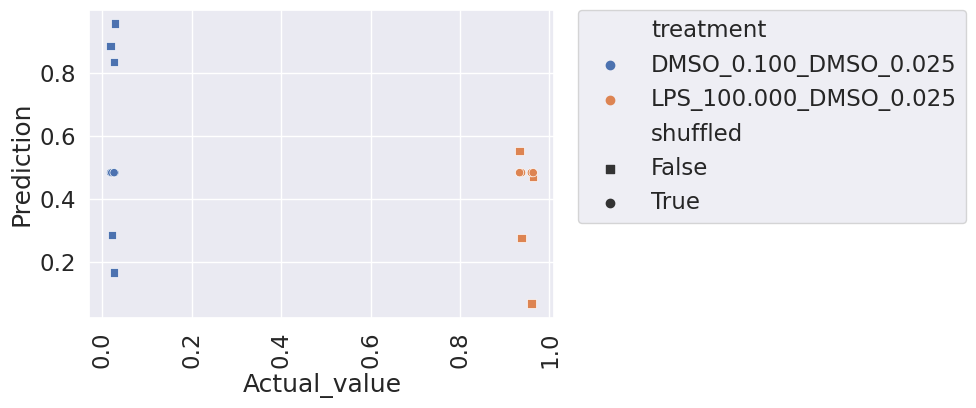

In [18]:
import matplotlib.pyplot as plt

# plot the compiled predictions
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(6, 4))

sns.scatterplot(
    x="Actual_value",
    y="Prediction",
    hue="treatment",
    style="shuffled",
    markers=["s", "o"],
    data=compiled_predictions,
    ax=ax,
)
plt.xticks(rotation=90)
# move the legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()